Housing Competition - kaggle

The most populular, classic regression problem from kaggle.com. With my approach described below, I've been able to climb up to 2883 out of 22538 spot (as of 26/03/2020), so almost top decile, so far.

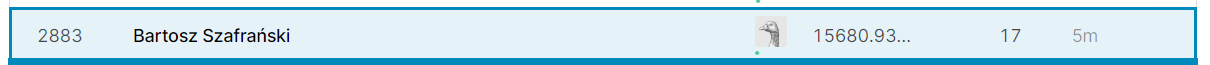

I won't describe the whole process thoroughly as there are lots of variables in this dataset, some poorly described, so I'll just highlight the most important points of data analysis and model building as we go.

In [68]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline
plt.style.use('fivethirtyeight')
pd.options.mode.chained_assignment = None

directory = 'C:\\Users\\Szafran\\Desktop\\python\\HousingPricesCompetition'
os.chdir(directory)

data = pd.read_csv('train.csv')
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(data, test_size=0.25)

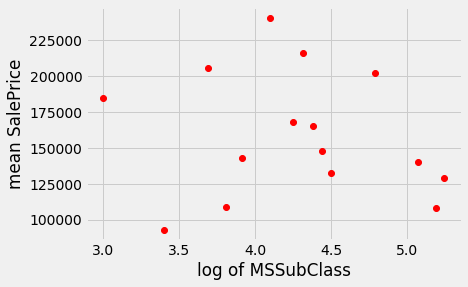

In [69]:
train_set['MSSubClass_log'] = train_set['MSSubClass'].apply(lambda x: math.log(x))

plt.plot(train_set.groupby('MSSubClass_log')['SalePrice'].mean(), 'ro')
plt.ylabel('mean SalePrice')
plt.xlabel('log of MSSubClass')
plt.show()

It might be worth a shot to explore including the square of the variable above as there might be a possibility to fit a parabola there.

Other variable manipulation I've found useful:

In [70]:
#taking log of Lot Area
train_set['LotArealog'] = [math.floor(math.log(x)) for x in train_set['LotArea']]

#merging some classes of LotShape
train_set['LotShape_simplified'] = train_set['LotShape'].where(train_set['LotShape']=='Reg', 'IR')

#merging some classes of LotConfig
train_set['LotConfig_simplified'] = train_set['LotConfig'].where(lambda x: (x=='CulDSac') | (x=='FR3'), 'Rest')
train_set['LotConfig_simplified'] = train_set['LotConfig_simplified'].where(lambda x: (x!='CulDSac') & (x!='FR3'), 'CulDeSac_TR3')

#merging some classes MasVnrType
train_set['MasVnr_simplified'] = ['None' if train_set['MasVnrType'][i] == 'None' else 'Present' for i in train_set.index]

#applying a square root to MasVnrArea
train_set['MasVnrSqrt'] = train_set['MasVnrArea'].apply(lambda x: x**0.5)

#merging some classes of Foundation
train_set['Foundation_simplified'] = ['PConc' if i=='PConc' else 'Rest' for i in train_set['Foundation']]

#merging some classes of BsmtFinType1
train_set['BsmtFinType1_simplified'] = ['GLQ' if i=='GLQ' else 'Rest' for i in train_set['BsmtFinType1']]

#creating a new variable- Baths which is a sum of all baths in a given house
train_set['Baths'] = train_set['BsmtFullBath'] + train_set['BsmtHalfBath'] + train_set['FullBath'] + train_set['HalfBath']
train_set['Baths'] = train_set['Baths'].where(train_set['Baths'] <4, 4)

#creating a variable is_fireplace which indicates whether there is a fireplace in the real estate
train_set['is_fireplace'] = [0 if i==0 else 1 for i in train_set['Fireplaces']]

#merging some classes of GarageCars
train_set['GarageCars'] = [3 if i >2 else i for i in train_set['GarageCars']]

#creating Porches which is a total area of porches in the real estate
train_set['Porches'] = train_set['WoodDeckSF'] + train_set['OpenPorchSF'] + train_set['EnclosedPorch'] + train_set['3SsnPorch'] + train_set['ScreenPorch']

#merging year and month - this might by useful in the future
train_set['date_sold'] = [str(train_set['MoSold'][i]) + "_" + str(train_set['YrSold'][i]) for i in train_set.index]

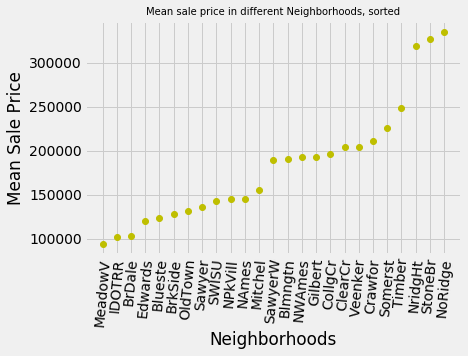

In [71]:
plt.plot(train_set.groupby(['Neighborhood'])['SalePrice'].mean().sort_values(), 'yo')
plt.xticks(rotation=85)
plt.ylabel('Mean Sale Price')
plt.xlabel('Neighborhoods')
plt.title('Mean sale price in different Neighborhoods, sorted', size=10)
plt.show()

It looks like an useful feature. Let's create a dictionary and map mean sale prices as values.

In [72]:
neighborhood_mapper = {}
for neigh in train_set['Neighborhood'].unique():
    neighborhood_mapper[neigh] = train_set[train_set['Neighborhood']==neigh]['SalePrice'].mean()

train_set['Neighborhood'] = train_set['Neighborhood'].map(neighborhood_mapper)

train_set['Neighborhood'].head()

1223    145078.242424
1314    120140.506329
1381    145078.242424
961     192912.358491
925     192912.358491
Name: Neighborhood, dtype: float64

Now we can proceed and start preparing the model. I'll use mean encoding to encode categorical variables - for each category, I will assign its mean target value in the train set.

In [73]:
#dividing features into categorical and numerical dataframes
features_cat = train_set[['MSSubClass_log', 'LandContour', 'BldgType', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'CentralAir', 'GarageFinish', 'BsmtFinType1_simplified']].copy()
features_num = train_set[['LotFrontage', 'Neighborhood', 'OverallQual', 'OverallCond', 'TotalBsmtSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'LotArealog', 'MasVnrSqrt', 'Baths', 'Porches']].copy()

#Dealing with missing values in features_cat:
for col in features_cat.columns:
    features_cat[col] = features_cat[col].fillna(features_cat[col].mode()[0])

#Dealing with missing values in numerical features
for col in features_num.columns:
    features_num[col] = features_num[col].fillna(features_num[col].mean())


#creating mean encoded variables in categoricals:
for col in features_cat.columns:
    features_cat[col] = features_cat[col].map(train_set.groupby(col)['SalePrice'].mean())

#standarizing numerical feats
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_num_stand = pd.DataFrame(scaler.fit_transform(features_num), columns=features_num.columns, index=train_set.index)
features_cat_stand = pd.DataFrame(scaler.fit_transform(features_cat), columns=features_cat.columns, index=train_set.index)

#combining it together
features_final = pd.concat([features_cat_stand, features_num_stand], axis=1)
    

Before proceeding, let's wrap data preparation into a function that we'll use to transform validation set and test set later on.

In [74]:
def feature_prepare(feats):
    feats['MSSubClass_log'] = feats['MSSubClass'].apply(lambda x: math.log(x))
    feats['LotArealog'] = [math.floor(math.log(x)) for x in feats['LotArea']]
    feats['LotShape_simplified'] = feats['LotShape'].where(feats['LotShape']=='Reg', 'IR')
    feats['LotConfig_simplified'] = feats['LotConfig'].where(lambda x: (x=='CulDSac') | (x=='FR3'), 'Rest')
    feats['LotConfig_simplified'] = feats['LotConfig_simplified'].where(lambda x: (x!='CulDSac') & (x!='FR3'), 'CulDeSac_TR3')
    feats['MasVnr_simplified'] = ['None' if feats['MasVnrType'][i] == 'None' else 'Present' for i in feats.index]
    feats['MasVnrSqrt'] = feats['MasVnrArea'].apply(lambda x: x**0.5)
    feats['Foundation_simplified'] = ['PConc' if i=='PConc' else 'Rest' for i in feats['Foundation']]
    feats['BsmtFinType1_simplified'] = ['GLQ' if i=='GLQ' else 'Rest' for i in feats['BsmtFinType1']]
    feats['Baths'] = feats['BsmtFullBath'] + feats['BsmtHalfBath'] + feats['FullBath'] + feats['HalfBath']
    feats['Baths'] = feats['Baths'].where(feats['Baths'] <4, 4)
    feats['is_fireplace'] = [0 if i==0 else 1 for i in feats['Fireplaces']]
    feats['GarageCars'] = [3 if i >2 else i for i in feats['GarageCars']]
    feats['Porches'] = feats['WoodDeckSF'] + feats['OpenPorchSF'] + feats['EnclosedPorch'] + feats['3SsnPorch'] + feats['ScreenPorch']
    feats['date_sold'] = [str(feats['MoSold'][i]) + "_" + str(feats['YrSold'][i]) for i in feats.index]
    feats['Neighborhood'] = feats['Neighborhood'].map(neighborhood_mapper)
    feats = feats.drop(['MSSubClass','WoodDeckSF', 'YrSold', 'MoSold', 'SaleType', 
                            'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                            'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', '1stFlrSF', 
                            'Fireplaces', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 
                            'Functional', 'GarageQual', 'GarageCond', 'FireplaceQu', 
                            'GarageType', '2ndFlrSF', 'LowQualFinSF', 'BsmtFinType1', 'Heating', 
                            'Electrical', 'Foundation', 'BsmtCond', 'MasVnrType', 'MasVnrArea', 
                            'ExterCond', 'Condition1', 'Condition2','RoofStyle', 'RoofMatl', 
                            'Exterior1st', 'Exterior2nd', 'LotShape', 'LotConfig', 'LandSlope', 
                            'Utilities', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 
                            'LotArea', 'Street', 'Alley', 'Id', 'BsmtHalfBath', 'BsmtFullBath',
                            'FullBath', 'HalfBath', 'SaleCondition'], axis=1)
    
    
    features_cat = feats[['MSSubClass_log', 'LandContour', 'BldgType', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'CentralAir', 'GarageFinish', 'BsmtFinType1_simplified']].copy()
    features_num = feats[['LotFrontage', 'Neighborhood', 'OverallQual', 'OverallCond', 'TotalBsmtSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'LotArealog', 'MasVnrSqrt', 'Baths', 'Porches']].copy()

    #Dealing with missing values in features_cat:
    for col in features_cat.columns:
        features_cat[col] = features_cat[col].fillna(features_cat[col].mode()[0])
        
    #Dealing with missing values in numerical features
    for col in features_num.columns:
        features_num[col] = features_num[col].fillna(features_num[col].mean())


    #creating mean encoded variables in categoricals:
    for col in features_cat.columns:
        features_cat[col] = features_cat[col].map(train_set.groupby(col)['SalePrice'].mean())
    
    #standarization of numerical feats
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    features_num_stand = pd.DataFrame(scaler.fit_transform(features_num), columns=features_num.columns, index=feats.index)
    features_cat_stand = pd.DataFrame(scaler.fit_transform(features_cat), columns=features_cat.columns, index=feats.index)
    #combine it together
    features_final = pd.concat([features_cat_stand, features_num_stand], axis=1)
    
    return features_final

In [75]:
target = train_set['SalePrice'].copy()

We'll use XGBRegressor on this one.

In [76]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(features_final, target)

val_y = val_set['SalePrice'].copy()
val_X = feature_prepare(val_set)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(val_y, model.predict(val_X)))

[14:08:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
16739.519188784245


Results, unfortunately, have very high variance - it if possible to obtain a very good score using this model (as low as 14 000), but sometimes mean absolute error jumps up to 20 000, depending on the choice of train and validation sets. 

The next objectives will be to:
- make the model more stable
- try adding polynomial features to the model
- remove unsignificant variables from the model
- try ensembling methods - combining regularized linear models with gradient boosted regressor.